# RNN Machine Translation Laboration

In this lab, your task is to build a sequence-to-sequence model, using recurrent neural networks, that translates short sentences from Swedish into English.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Tensorflow is quite chatty; filter out warnings

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Check that Tensorflow uses a GPU _(optional)_

Training the models in this notebook can be sped up significantly with a GPU.  The following cell can be used to check if the GPU is set up correctly.  If you run on CPU, you can either run or just ignore this cell.

In [3]:
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# # The GPU id to use, usually either "0" or "1"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# if tf.config.list_physical_devices("GPU"):
#     print("✓ Tensorflow has detected a GPU.")
#     import shutil
#     if not shutil.which("ptxas"):
#         print("\n✗ Command 'ptxas' not found in path -- you might have to install `cudatoolkit-dev`")
#     if not "XLA_FLAGS" in os.environ:
#         print("\n✗ XLA_FLAGS not set. If you encounter errors during training, you might have to set")
#         print("        XLA_FLAGS=\"--xla_gpu_cuda_data_dir=$CONDA_PREFIX/lib/\"")
    
#     # Allow growth of GPU memory, otherwise it will always look like all the memory is being used
#     physical_devices = tf.config.experimental.list_physical_devices('GPU')
#     tf.config.experimental.set_memory_growth(physical_devices[0], True) 
# else:
#     print("✗ Tensorflow has NOT detected a GPU.")
#     print()
#     print("For GPU support, visit: <https://www.tensorflow.org/install/pip>")

## Problem Specification

Your task in this assignment is to:

1. Build an encoder—decoder model based on recurrent neural networks.
2. Train this model on the provided training data, a collection of parallel Swedish–English sentences.
3. Evaluate the performance of this model on the provided test data.

### The data: Swedish–English Anki corpus

The data in this lab consists of bilingual Swedish–English sentence pairs from the [Tatoeba Project](https://tatoeba.org/en) as collected by [Anki](http://www.manythings.org/anki/).  These are comparatively short sentences, suitable for language learners, and therefore also well-suited for building a small machine translation model. Here are some example sentences from the training set:

In [4]:
with open("en-sv-train.txt", "rt") as f:
    for i, line in enumerate(f):
        pair = [sent for sent in line.rstrip().split("\t")]
        print(pair)
        if i > 2:
            break

['i returned to japan .', 'jag återvände till japan .']
['i love her .', 'jag älskar henne .']
["this is tom ' s school .", 'detta är toms skola .']
['i can hardly stand .', 'jag kan knappt stå .']


Each line in the data files consists of an English–Swedish sentence pair. The sentences are already lower-cased and pre-tokenized (using the [toktok tokenizer from NLTK](https://www.nltk.org/howto/tokenize.html)), so we can simply split them up by whitespace to get sequences of tokens.  To make your life a bit easier, we have removed sentences longer than 15 words. 

The next cell contains code that yields the sentences contained in a file as lists of strings:

In [5]:
ENGLISH = 0
SWEDISH = 1

def sentences(filename, idx):
    # Use idx=0 for English, idx=1 for Swedish
    with open(filename, "rt") as source:
        for line in source:
            yield line.rstrip().split("\t")[idx].split()

# Example usage
next(sentences("en-sv-train.txt", ENGLISH))

['i', 'returned', 'to', 'japan', '.']

## Part 1: Build the vocabularies

Before we can feed them into any model, we first need to convert the text strings to integers. For this purpose, we'll create a **vocabulary** of tokens that are known to the model, one vocabulary for each language. We need four **special tokens (or "pseudowords")**:

1. `<pad>` at index 0 for padding purposes
2. `<unk>` at index 1 to represent unknown words
3. `<bos>` at index 2 to mark the "beginning of sequence" in the decoder
4. `<eos>` at index 3 to mark the "end of sequence" in the decoder

The remaining items in the vocabulary should be made up of the **most frequent words** in the training data for the respective language.

#### 🤔 Task 1: Write the function to build the vocabularies

In [6]:
from collections import Counter

def make_vocab(sentences, max_size):
    """Return a list of the `max_size` most frequent tokens in `sentences`."""

    vocabulary = ['<pad>', '<unk>', '<bos>', '<eos>']
               
    freqDict = {}
    #{wordA:count}
    try:
            
        # TODO
        # 1. Count of how often each word occurs in the data
        for line in sentences:
            for word in line:
                if word in freqDict:
                    freqDict[word] += 1
                else:
                    freqDict[word] = 1
        # 2. Sort the words by their frequency, in descending order
        freqList = sorted(freqDict,key=lambda key: freqDict[key], reverse=True)
        # 3. Make a list of the special tokens plus the most frequent words, up to a length of `max_size`.
        vocabulary.extend(freqList)
        vocabularyFirstM = vocabulary[:max_size]
        # 4. Return the list
        return vocabularyFirstM
    except:
        raise NotImplementedError

With this function, we can construct vocabularies containing the 5,000 most frequent words as follows:

In [7]:
src_vocab = make_vocab(sentences('en-sv-train.txt', SWEDISH), 5000)
tgt_vocab = make_vocab(sentences('en-sv-train.txt', ENGLISH), 5000)

In [8]:
print(src_vocab[:10])
print(tgt_vocab[:10])

['<pad>', '<unk>', '<bos>', '<eos>', '.', 'jag', 'är', '?', 'tom', 'det']
['<pad>', '<unk>', '<bos>', '<eos>', '.', 'i', "'", 'tom', '?', 'you']


#### 🤞 Test your code

To test your code, check that each vocabulary contains 5,000 words, and includes the pseudowords at the right positions:

In [9]:
def test1():
    assert len(src_vocab) == 5000
    assert len(tgt_vocab) == 5000
    assert src_vocab[:4] == ['<pad>', '<unk>', '<bos>', '<eos>']
    assert tgt_vocab[:4] == ['<pad>', '<unk>', '<bos>', '<eos>']
    print("All good!")

test1()

All good!


### Wrap the vocabularies in StringLookup layers

For mapping tokens to their vocabulary IDs, we can use Keras' `StringLookup` layer. The next cell constructs layers for both the source and target vocabulary.

In [10]:
string_lookup_args = dict(output_mode="int", mask_token="<pad>", oov_token="<unk>")
src_lookup = layers.StringLookup(vocabulary=src_vocab, **string_lookup_args)
tgt_lookup = layers.StringLookup(vocabulary=tgt_vocab, **string_lookup_args)

The next cell gives an example how these `StringLookup` layers can be used. Note that the layers already return *tensors*.

In [11]:
example = "i returned to japan yesterday .".split()
print(tgt_lookup(example))

tf.Tensor([   5 1005   11  530  188    4], shape=(6,), dtype=int64)


#### 🤔 Task 2: Sanity-check that these numbers are correct

Check your understanding of what's happening in the `StringLookup` layer by writing two lines of code:
1. One that prints the token corresponding to the _second integer_ in the tensor above.
2. One that prints the integer corresponding to the _second word_ ("returned") in the example above.

Use `tgt_vocab` directly for that, not the lookup layer!

In [12]:
## TODO: Your code here
print(tgt_vocab[1005])
print(tgt_vocab.index('returned'))


returned
1005


### Wrapping everything in data loaders

The next cell defines a function that wraps our dataset in TensorFlow's [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API, which represents map-style datasets. The advantage of this is that it lets us use standard infrastructure related to the loading and automatic batching of data.

In [13]:
def append_eos(tensor):
    "Helper function that appends '<eos>' to a sequence."
    return tf.concat([tensor, tf.constant(["<eos>"], dtype=tf.string)], axis=0)

def load_translation_dataset(src_lookup, tgt_lookup, filename):
    # Build source dataset and convert with src_lookup
    src_dataset = tf.data.Dataset.from_tensor_slices(
        tf.ragged.constant(list(sentences(filename, SWEDISH)))
    )
    src_dataset = src_dataset.map(src_lookup)

    # Build target dataset, append <eos> and convert with tgt_lookup
    tgt_dataset = tf.data.Dataset.from_tensor_slices(
        tf.ragged.constant(list(sentences(filename, ENGLISH)))
    )
    tgt_dataset = tgt_dataset.map(append_eos).map(tgt_lookup)
    
    # Zip them together
    return tf.data.Dataset.zip((src_dataset, tgt_dataset))

We load the training data:

In [14]:
train_dataset = load_translation_dataset(src_lookup, tgt_lookup, "en-sv-train.txt")

The following function can be helpful for debugging. It extracts a single source–target pair of sentences from the specified *dataset* and converts it into batches of size&nbsp;1, which can be fed into the encoder–decoder model. This also illustrates how the `Dataset` API works:

In [15]:
def example(dataset, i):
    if i > 0:
        dataset = dataset.skip(i-1)
    return list(dataset.take(1).batch(1))[0]

In [16]:
x, y = example(train_dataset, 42)
print(x)
print(y)

tf.Tensor([[  6  10 245  15  20   7]], shape=(1, 6), dtype=int64)
tf.Tensor([[ 29   9 477  55  28   8   3]], shape=(1, 7), dtype=int64)


## Part 2: The encoder–decoder architecture

In this section, you will implement the encoder–decoder architecture, including the extension of that architecture by an attention mechanism. The implementation consists of four parts: the encoder, the attention mechanism, the decoder, and a class that wraps the complete architecture.

### Part 2.1: Implement the encoder

The encoder is a component that takes an input tensor of vocabulary IDs, like the `x` tensor from the example above, and performs the following steps:

1. Look up **word embeddings** for each token in the sequence.
2. Process them with a **bi-directional recurrent neural network**. This works with any type of RNN, but we will use **GRU (gated recurrent unit) layers** throughout this laboration.
3. Feed the output through a linear layer. We also take the last hidden state of the forward GRU and the last hidden state of the backward GRU, concatenate them, and pass them through a linear layer. This produces a "summary" of the source sentence, which we will later feed into the decoder.

Let's implement the encoder by defining it as a **custom Keras layer.** For this, we have to define a class that subclasses from `keras.layers.Layer`, instantiate all required model weights and/or (sub)layers in the `__init__()` function, and uses them to perform the layer's computation in the `call()` function. Below is some skeleton code to get you started; you can also [read more about making custom layers in the Keras Docs](https://keras.io/guides/making_new_layers_and_models_via_subclassing/).

#### 🤔 Task 3: Implement the encoder by completing the skeleton code below

In [17]:
class Encoder(layers.Layer):
    def __init__(self, num_words, embedding_dim=128, hidden_dim=256):
        super().__init__()
        # TODO: Add your code here that defines the required layers/weights
        self.embedding = layers.Embedding(input_dim = num_words, output_dim = embedding_dim, mask_zero = True)
        self.rnn = layers.Bidirectional(layers.GRU(hidden_dim, return_sequences = True, return_state = True))
        self.linear = layers.Dense(hidden_dim)

    def call(self, inputs):
        # TODO
        # 1. Look up the embeddings for the source words
        x = self.embedding(inputs)
        # 2. Apply a bi-directional GRU over the source sequences
        output, last_state1, last_state2  = self.rnn(x)
        # 3. Apply a linear transformation to the GRU's output
        output = self.linear(output)
        # 4. Concatenate forward + backward hidden states and apply a linear transformation on them too
        state = layers.concatenate([last_state1,last_state2],axis=1)
        hidden = self.linear(state)
        return (output, hidden)

        raise NotImplementedError

Your code must comply with the following specification:

**__init__** (*num_words*, *embedding_dim* = 128, *hidden_dim* = 256)

> Initialises the encoder. The encoder consists of an embedding layer that maps each of *num_words* words to an embedding vector of size *embedding_dim*, a bidirectional GRU that maps each embedding vector to a position-specific representation of size 2 × *hidden_dim*, and a final linear layer that projects these representations to new representations of size *hidden_dim*.

**call** (*self*, *inputs*)

> Takes a tensor *inputs* with source-language word ids and sends it through the encoder. The input tensor has shape (*batch_size*, *src_len*), where *src_len* is the length of the sentences in the batch. (We will make sure that all sentences in the same batch have the same length.) The method returns a pair of tensors (*output*, *hidden*), where *output* has shape (*batch_size*, *src_len*, *hidden_dim*), and *hidden* has shape (*batch_size*, *hidden_dim*).

#### 🤞 Test your code

To test your code, instantiate an encoder, feed it the first source sentence in the training data, and check that the tensors returned by the encoder have the expected shapes.

In [18]:
def test21():
    src, tgt = example(train_dataset, 42)
    encoder = Encoder(src_lookup.vocabulary_size())
    output, hidden = encoder(src)
    print(output.shape)  # should be (batch_size, src_len, hidden_dim)
    print(hidden.shape)  # should be (batch_size, hidden_dim)

test21()

(1, 6, 256)
(1, 256)


In [19]:
#test
src, tgt = example(train_dataset, 42)
encoder = Encoder(src_lookup.vocabulary_size())
output, hidden = encoder(src)
outputt, hiddent = encoder(src)
outputt[:,:,255] == outputt[:,:,-1]

<tf.Tensor: shape=(1, 6), dtype=bool, numpy=array([[ True,  True,  True,  True,  True,  True]])>

### Part 2.2: Implement the attention mechanism

Your next task is to implement the attention mechanism. Recall that the purpose of this mechanism is to inform the decoder when generating the translation of the next word. For this, attention has access to the previous hidden state of the decoder, as well as the complete output of the encoder. It returns the attention-weighted sum of the encoder output, the so-called *context* vector. For later usage, we also return the attention weights.

As mentioned in the lecture, attention can be implemented in various ways. One very simple implementation is *uniform attention*, which assigns equal weight to each position-specific representation in the output of the encoder, and completely ignores the hidden state of the decoder. This mechanism is implemented in the cell below:

In [19]:
class UniformAttention(layers.Layer):
    def __init__(self):
        super().__init__()
        self.supports_masking = True

    def call(self, decoder_hidden, encoder_output, mask=None):
        # Set all attention scores to the same constant value (0). After
        # the softmax, we will have uniform weights.
        scores = tf.zeros_like(encoder_output[:, :, -1])
        # <tf.Tensor: shape=(1, 6), dtype=float32, numpy= ... > -1:last element
        
        # Mask out the attention scores for the padding tokens. We set
        # them to -inf. After the softmax, we will have 0.
        if mask is not None:
            masked_value = -float('inf') * tf.ones_like(scores)
            scores = tf.where(mask, scores, masked_value)
        
        # Convert scores into weights
        alpha = tf.nn.softmax(scores, axis=1)
        
        # The context is the alpha-weighted sum of the encoder outputs.
        context = tf.linalg.matmul(tf.expand_dims(alpha, axis=1), encoder_output)
        # (1,1,6) %*% (1,6,256) -> (1,1,256)
        context = tf.squeeze(context, axis=1)
        # (1,1,256)-> (1,256)
        
        return alpha, context

One technical detail in this code is our use of *mask* to compute attention weights only for the ‘real’ tokens in the source sentences, but not for the padding tokens that we introduce to bring all sentences in a batch to the same length.

Your task now is to implement the attention mechanism from the paper by [Bahdanau et al. (2015)](https://arxiv.org/abs/1409.0473). The relevant equation is in Section&nbsp;A.1.2:

$$
a(s_{i-1}, h_j) = v^{\top} \tanh(W s_{i-1} + U h_j)
$$

This equation specifies how to compute the attention score (a scalar) for the previous hidden state of the decoder, denoted by $s_{i-1}$, and the $j$-th position-specific representation in the output of the encoder, denoted by $h_j$. The equation refers to three parameters: a vector $v$ and $W$ and $U$. In PyTorch, these parameters can be represented in terms of (bias-free) linear layers that are trained along with the other parameters of the model.

Here is the skeleton code for this problem. As you can see, your specific task is to initialise the required parameters and to compute the attention scores (*scores*); the rest of the code is the same as for the uniform attention.

#### 🤔 Task 4: Implement Bahdanau attention by completing the skeleton code below

In [20]:
class BahdanauAttention(layers.Layer):
    def __init__(self, hidden_dim=256):
        super().__init__()
        self.supports_masking = True
        # TODO: Add your code here that defines the required layers/weights
        # self.w = layers.Dense(hidden_dim*hidden_dim,use_bias = False) # n*n
        # self.w = layers.Reshape((hidden_dim,hidden_dim))
        # self.w = layers.Dense(hidden_dim*hidden_dim,use_bias = False) # n*n
        # self.u = layers.Dense(2*hidden_dim*hidden_dim,use_bias = False) # n*n
        # self.v = layers.Dense(hidden_dim,use_bias = False) # n vector
        self.w = layers.Dense(hidden_dim,use_bias = False)
        self.u = layers.Dense(hidden_dim,use_bias = False) # n*n
        self.v = layers.Dense(1,use_bias = False) # n vector

    def call(self, decoder_hidden, encoder_output, mask=None):
        # s:decoder_hidden: shape(batch_size, hidden_dim)
        # h:encoder_output: shape(batch_size, src_len, hidden_dim)
        # TODO: Replace the next line with your own code that computes the attention scores
        uh = self.u(encoder_output) # (batch_size, src_len, hidden_dim)
        ws = self.w(tf.expand_dims(decoder_hidden, 1)) # (batch_size, 1, hidden_dim)
        scores = self.v(tf.nn.tanh(uh+ws)) # (batch_size, src_len, 1)
        scores = tf.squeeze(scores, axis=2) # (batch_size, src_len)

        # ... The rest of the code is as in UniformAttention — NO NEED TO MODIFY BELOW THIS LINE!

        # Mask out the attention scores for the padding tokens. We set
        # them to -inf. After the softmax, we will have 0.
        if mask is not None:
            masked_value = -float('inf') * tf.ones_like(scores)
            scores = tf.where(mask, scores, masked_value)
        
        # Convert scores into weights
        alpha = tf.nn.softmax(scores, axis=1)
        # alpha: shape(batch_size, src_len)
        
        # The context is the alpha-weighted sum of the encoder outputs.
        context = tf.linalg.matmul(tf.expand_dims(alpha, axis=1), encoder_output)
        context = tf.squeeze(context, axis=1)
        # context: shape(batch_size, hidden_dim)
        
        return alpha, context

Your code must comply with the following specification:

**call** (*decoder_hidden*, *encoder_output*, *mask*)

> Takes the previous hidden state of the decoder (*decoder_hidden*) and the encoder output (*encoder_output*) and returns a pair (*alpha*, *context*) where *context* is the context as computed as in [Bahdanau et al. (2015)](https://arxiv.org/abs/1409.0473), and *alpha* are the corresponding attention weights. The hidden state has shape (*batch_size*, *hidden_dim*), the encoder output has shape (*batch_size*, *src_len*, *hidden_dim*), the context has shape (*batch_size*, *hidden_dim*), and the attention weights have shape (*batch_size*, *src_len*).

#### 💡 Hints on the implementation

You may need a few more "low-level" TensorFlow functions to implement this part, concretely:
    
- `tf.expand_dims()` and `tf.squeeze()` to add/remove a dimension from a tensor. This is because some tensors have a "timestep" dimension while others (e.g. the hidden state of the decoder) don't.
- `tf.nn.tanh()` to compute the $\tanh$ function on a tensor.

#### 🤞 Test your code

To test your code, extend your test from Task 3: Feed the output of your encoder into your attention class. As the previous hidden state of the decoder, you can use the hidden state returned by the encoder. Later, you don't need to pass the mask explicitly (Keras will do this automatically), but for testing purposes, you can obtain the mask from a layer's output via `output._keras_mask`.

Check that the context tensor and the attention weights returned by the attention class have the expected shapes.

In [21]:
def test22():
    src, tgt = example(train_dataset, 42)
    encoder = Encoder(src_lookup.vocabulary_size())
    output, hidden = encoder(src)

    

    attention = BahdanauAttention()
    alpha, context = attention(hidden, output, mask=output._keras_mask)
    print(alpha.shape)    # should be (batch_size, src_len)
    print(context.shape)  # should be (batch_size, hidden_dim)

test22()

(1, 6)
(1, 256)


### Part 2.3: Implement the decoder

Now you are ready to implement the decoder. Like the encoder, the decoder is based on a GRU; but this time we use a unidirectional network, as we generate the target sentences left-to-right.

**⚠️ We expect that solving this problem will take you the longest time in this lab.**

Because the decoder is an autoregressive model, we need to unroll the GRU "manually": At each position, we take the previous hidden state as well as the new input, and apply the GRU for one step. The initial hidden state comes from the encoder. The new input is the embedding of the previous word, concatenated with the context vector from the attention model. To produce the final output, we take the output of the GRU, concatenate the embedding vector and the context vector (residual connection), and feed the result into a linear layer. Here is a graphical representation:

<img src="https://gitlab.liu.se/nlp/nlp-course/-/raw/master/labs/l3/decoder.svg" width="50%" alt="Decoder architecture"/>

We need to implement this manual unrolling for two very similar tasks: When *training*, both the inputs to and the target outputs of the GRU come from the training data. When *decoding*, the outputs of the GRU are used to generate new target-side words, and these words become the inputs to the next step of the unrolling. **We have already implemented the `call` method that handles both these two different modes of usage — you don't need to modify this.**

#### 🤔 Task 5: Implement the `step` method that takes a single step with the GRU

You will also need to add any necessary layers/weights that you use in the `__init__` function.

In [22]:
class Decoder(layers.Layer):
    def __init__(self, trg_lookup, attention, embedding_dim=128, hidden_dim=256, max_len=16):
        super().__init__()
        num_words = trg_lookup.vocabulary_size()
        self.embedding = layers.Embedding(num_words, embedding_dim, mask_zero=True)
        self.bos_index = trg_lookup(["<bos>"]).numpy()
        self.max_len = max_len
        # TODO: Add your code here that defines the required layers/weights
        self.attention = BahdanauAttention()
        self.rnn_cell = layers.GRUCell(hidden_dim)
        self.linear = layers.Dense(num_words)

    def call(self, encoder_output, initial_state, targets=None, training=False, mask=None):
        # YOU WON'T NEED TO MODIFY ANYTHING IN THIS FUNCTION.

        if training:
            assert targets is not None

        # Initialise the hidden state from `initial_state`
        state = initial_state
        
        # Initialise the decoder input with the `<bos>` symbol
        next_input = self.bos_index * tf.ones_like(initial_state, dtype=tf.int64)
        next_input = next_input[:, 0]
        
        # Initialise the list of outputs and attention weights
        outputs = tf.TensorArray(
            tf.float32,
            size=0 if training else self.max_len,
            dynamic_size=training,
        )
        alphas = tf.TensorArray(
            tf.float32,
            size=0 if training else self.max_len,
            dynamic_size=training,
        )
        inputs = tf.TensorArray(
            tf.int64,
            size=0 if training else self.max_len,
            dynamic_size=training,
        )

        # In training mode, we iterate over the length of the target sentences,
        # otherwise we iterate until `self.max_len` is reached
        max_len = tf.shape(targets)[1] if training else self.max_len
        
        for i in range(max_len):
            # In training mode, we feed the correct (gold) predictions as the next input
            if training and i > 0:
                next_input = targets[:, i-1]
            
            # Get the embedding for the previous word
            prev_embed = self.embedding(next_input)
            
            # Take one step with the RNN
            step_output, state, alpha = self.step(encoder_output, state, prev_embed, mask=mask)
            
            # Update the list of generated words and attention weights
            outputs = outputs.write(i, step_output)
            alphas = alphas.write(i, alpha)
            inputs = inputs.write(i, next_input)

            # Set the prediction with highest probability as the input for the next timestep
            if not training:
                next_input = tf.math.argmax(step_output, axis=-1)

        # Lists of outputs and attention weights are [tgt_len, batch_size, *],
        # so we transpose them to have the batch dimension in first place again.
        outputs = tf.transpose(outputs.stack(), perm=[1,0,2])
        alphas = tf.transpose(alphas.stack(), perm=[1,0,2])
        inputs = tf.transpose(inputs.stack(), perm=[1,0])
        outputs._keras_mask = (inputs != 0)
        
        return outputs, alphas
    
    def step(self, encoder_output, hidden_state, prev_embed, mask=None):
        # TODO: Replace the next line with your own code; this should follow the illustration above.
        # 1. Get the attention weights and context vector
        alpha, context = self.attention(hidden_state, encoder_output, mask=mask)
        # 2. Concatenate the inputs for the GRU
        rnn_input = layers.concatenate([context, prev_embed],axis=1)
        # 3. Take one step with the GRU cell
        rnn_output, hidden_state = self.rnn_cell(rnn_input, hidden_state)
        # 4. Concatenate the respective tensors to produce the final output
        output = layers.concatenate([rnn_input, rnn_output],axis=1)
        output = self.linear(output)
        
        return output, hidden_state, alpha

Your implementation should comply with the following specification:

**step** (*self*, *encoder_output*, *hidden*, *prev_embed*, *mask*)

> Performs a single step in the manual unrolling of the decoder GRU. This takes the output of the encoder (*encoder_output*), the previous hidden state of the decoder (*hidden*), the embedding vector of the previous word (*prev_embed*), and the source mask as described in Problem&nbsp;2.2 (*mask*), and computes the output as described above.
>
> The shape of *encoder_output* is (*batch_size*, *src_len*, *hidden_dim*); the shape of *hidden* is (*batch_size*, *hidden_dim*); the shape of *src_mask* is (*batch_size*, *src_len*); and the shape of *prev_embed* is (*batch_size*, *embedding_dim*).
>
> The method returns a triple of tensors (*output*, *hidden*, *alpha*) where *output* is the position-specific output of the GRU, of shape (*batch_size*, *num_words*); *hidden* is the new hidden state, of shape (*batch_size*, *hidden_dim*); and *alpha* are the attention weights that were used to compute the *output*, of shape (*batch_size*, *src_len*).

#### 💡 Hints on the implementation

**GRU vs. GRUCell.** In Keras, an RNN layer like `GRU` is used to process an entire sequence. A single *time-step* of a sequence is handled by a [`GRUCell`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRUCell) instead. You can think of a `GRU` layer as functionally equivalent to a for-loop around a `GRUCell`. Since we want to perform the RNN steps individually for this model, you should use a [`GRUCell`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRUCell) instead of a `GRU` layer here.

#### 🤞 Test your code

To test your code, extend your test from the previous problems, and simulate a complete forward pass of the encoder–decoder architecture on the example sentence. Check the shapes of the resulting tensors.

In [23]:
def test23():
    src, tgt = list(train_dataset.take(4).padded_batch(4))[0]
    encoder = Encoder(src_lookup.vocabulary_size())
    encoder_output, hidden = encoder(src)
    attention = BahdanauAttention()
    decoder = Decoder(tgt_lookup, attention)
    decoded, alphas = decoder(encoder_output, hidden)
    print(decoded.shape)  # should be (batch_size, max_len, vocabulary_size)
    print(alphas.shape)   # should be (batch_size, max_len, src_len)
    decoded, _ = decoder(encoder_output, hidden, targets=tgt, training=True)
    print(decoded.shape)  # should be (batch_size, tgt_len, vocabulary_size)

test23()

(4, 16, 5000)
(4, 16, 5)
(4, 8, 5000)


### Encoder–Decoder wrapper class

The last part of the implementation is a class that wraps the encoder and the decoder as a single model.  We also implement a custom `train_step` function so that the gold targets will get passed to the decoder during training, and a custom `test_step` function to make sure the decoded sequences and the gold sequences are padded to the same length before computing losses and evaluation metrics.

In [24]:
class EncoderDecoder(keras.Model):
    def __init__(self, src_lookup, tgt_lookup, embedding_dim=128, hidden_dim=256, max_len=16, **kwargs):
        super().__init__(**kwargs)
        self.encoder = Encoder(
            src_lookup.vocabulary_size(),
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim
        )
        self.decoder = Decoder(
            tgt_lookup,
            BahdanauAttention(hidden_dim=hidden_dim),
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            max_len=max_len,
        )
    
    def call(self, inputs, training=False, targets=None):
        x_out, x_hidden = self.encoder(inputs, training=training)
        outputs, alphas = self.decoder(x_out, x_hidden, training=training, targets=targets)
        if training:
            return outputs
        else:
            return outputs, alphas
    
    # Following <https://keras.io/guides/customizing_what_happens_in_fit/>
    def train_step(self, data):
        x, y = data
        
        with tf.GradientTape() as tape:
            # Here we supply "targets" so that the decoder has access to it
            y_pred = self(x, training=True, targets=y)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred, _alphas = self(x, training=False)

        # Pad sequences to the same number of time-steps
        max_len = tf.math.maximum(tf.shape(y)[1], tf.shape(y_pred)[1])
        y_pad = [[0, 0], [0, max_len - tf.shape(y)[1]]]
        y = tf.pad(y, y_pad)
        y_pred_pad = [[0, 0], [0, max_len - tf.shape(y_pred)[1]], [0, 0]]
        y_pred = tf.pad(y_pred, y_pred_pad)
            
        self.compute_loss(x, y, y_pred, None)
        return self.compute_metrics(x, y, y_pred, None)

#### 🤞 Test your code

As a final test, instantiate an encoder–decoder model and use it to decode the example sentence. Check the shapes of the resulting tensors.

In [25]:
def test24():
    src, tgt = example(train_dataset, 42)
    encoder_decoder = EncoderDecoder(src_lookup, tgt_lookup)
    outputs, alphas = encoder_decoder(src)
    print(outputs.shape)  # should be (batch_size, max_len, vocabulary_size)
    print(alphas.shape)   # should be (batch_size, max_len, src_len)

test24()

(1, 16, 5000)
(1, 16, 6)


## Part 3: Train a translator

We now have all the pieces to build and train a complete translation system.

### Translator class

We first define a class `Translator` that initialises an encoder–decoder model and uses it to translate sentences.

In [26]:
class Translator:
    def __init__(self, src_lookup, tgt_lookup, batch_size=32, **kwargs):
        self.src_lookup = src_lookup
        self.tgt_lookup = tgt_lookup
        self.model = EncoderDecoder(src_lookup, tgt_lookup, **kwargs)
        self.tgt_vocab = tgt_lookup.get_vocabulary()
        self.eos_index = self.tgt_vocab.index("<eos>")
        self.batch_size = batch_size

    def compile(self, *args, **kwargs):
        return self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def translate(self, sentences, return_alphas=False):
        """This function takes sentences and returns their translation as a string.
        
        `sentences` can be either:
          - A tf.data.Dataset object
          - A list of strings
        """
        if isinstance(sentences, tf.data.Dataset):
            inputs = sentences
        elif isinstance(sentences, (list, tuple)):
            inputs = (
                tf.data.Dataset.from_tensor_slices(
                    tf.ragged.constant([x.split() for x in sentences])
                )
                .map(self.src_lookup)
                .padded_batch(min(self.batch_size, len(sentences)))
            )
        else:
            raise ValueError(f"'sentences' should be either a tf.Dataset or a list of strings; got: {type(sentences)}")

        outputs, alphas = self.model.predict(inputs, verbose=0)
        outputs = tf.math.argmax(outputs, axis=-1).numpy().tolist()
        try:
            alphas = alphas.numpy().tolist()
        except AttributeError:
            alphas = alphas.tolist()
        generated = []

        for y_pred, alpha in zip(outputs, alphas):
            try:
                eos_idx = y_pred.index(self.eos_index)
                del y_pred[eos_idx:]
                del alpha[eos_idx:]
            except ValueError:
                pass
            tokens = [self.tgt_vocab[idx] for idx in y_pred if idx > 0]
            tokens = " ".join(tokens)
            if return_alphas:
                generated.append((tokens, alpha))
            else:
                generated.append(tokens)

        return generated
        
    def translate_with_attention(self, sentences):
        return self.translate(sentences, return_alphas=True)

The code below shows how this class is supposed to be used (its output will be nonsensical right now, of course, since the model hasn't been trained yet):

In [27]:
translator = Translator(src_lookup, tgt_lookup)
# Alternative "mini" version of the model for testing:
#translator = Translator(src_lookup, tgt_lookup, embedding_dim=32, hidden_dim=64, batch_size=16, max_len=8)
translator.translate(['stäng av vattnet .', 'jag älskar friterade bananer .'])

['virus crafty in stew injured weekdays washing bombing known clear crowbar crack again was wearing warning',
 'cursive race wall pair taller fainted regret buys rainbow each released disagrees willing adjustments thinking oh']

### Evaluation function

As mentioned in the lecture, machine translation systems are typically evaluated using the **BLEU metric**. Here we use the implementation of this metric from the `sacrebleu` library.

In [29]:
from sacrebleu.metrics import BLEU
bleu_params = dict(effective_order=True, tokenize="none", force=True, smooth_method="floor", smooth_value=0.01)
bleu = BLEU(**bleu_params)

If the test sentence is exactly identical to the reference sentence, the score will be 100 (plus/minus potential floating point rounding errors):

In [30]:
bleu.sentence_score("the house is blue .", ["the house is blue ."]).score

100.00000000000004

If we change some words, the score will go down, though never below zero:

In [31]:
bleu.sentence_score("the house was red .", ["the house is blue ."]).score

3.9763536438352522

Here is a helper function that takes a trained `Translator` model as well as a `Dataset`, runs all sentences through the translator, and computes the BLEU score for the entire dataset:

In [32]:
def compute_bleu(translator, dataset):
    hyp = translator.translate(dataset)
    ref = [
        " ".join(translator.tgt_vocab[idx] for idx in s if idx not in (0, translator.eos_index))
        for s in dataset.unbatch().map(lambda _, x: x).as_numpy_iterator()
    ]
    return bleu.corpus_score(hyp, [ref]).score

We want to report the BLEU score on the **validation data**, so let's load this as well:

In [33]:
valid_dataset = load_translation_dataset(src_lookup, tgt_lookup, "en-sv-valid.txt")

### Batching

So far we only tested our code on "batches" with a single sentence. In order to use larger batches, we need to make sure that all of the sentences in a batch have the same length. We achieve this by _padding_ the shorter sentences to the length of the longest one. Luckily, the `tf.Dataset` class has a function [`padded_batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch) that will do this for us. If we provide a `Dataset` for training, Keras won't shuffle the data automatically, so we also have to [`shuffle`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) the dataset explicitly. (For validation, shuffling doesn't matter.)

In [34]:
train_batched = train_dataset.shuffle(512).padded_batch(64)
valid_batched = valid_dataset.padded_batch(64)

### Training

Training works as for any other Keras model: we first need to `compile` the model with the optimizer, loss function, and validation metrics that we want to use.

In [35]:
translator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

Now it is time to train the system. During training, these diagnostics will be updated periodically: the running average of the training loss; after a full epoch, the loss and the BLEU score on the validation data will be computed and printed.

Let's also define a callback that additionally prints the translation of a sample sentence, *jag saknar min familj* (which should translate into *i miss my family*), every 50 batches:

In [36]:
my_callbacks = [
    keras.callbacks.LambdaCallback(
        on_train_batch_end=lambda b, _: tf.print(" - jag saknar min familj . ->", translator.translate(['jag saknar min familj .'])[0]) if b > 0 and b % 50 == 0 else None,
        on_epoch_end=lambda _, l: l.__setitem__("val_bleu", compute_bleu(translator, valid_batched))
    )
]

#### 🤔 Task 6: Run the model training

Run the following code cells that train the model and evaluate it on the validation data.

Training the translator takes quite a bit of compute power and time. The default number of epochs is 2; however, you may want to try training for longer, or interrupt the training prematurely and use a partially trained model in case you run out of time.

**⚠️ Your submitted notebook must contain output demonstrating at least 20 BLEU points on the validation data.**

In [37]:
%%time
try:
    translator.fit(train_batched, epochs=2, validation_data=valid_batched, callbacks=my_callbacks)
except KeyboardInterrupt:
    pass

Epoch 1/2
322/322 [==============================] - 142s 410ms/step - loss: 3.2209 - val_loss: 4.3177 - val_bleu: 15.3770
Epoch 2/2
322/322 [==============================] - 114s 354ms/step - loss: 1.6832 - val_loss: 4.5850 - val_bleu: 29.4095
CPU times: user 12min 10s, sys: 24.4 s, total: 12min 34s
Wall time: 4min 16s


In [38]:
compute_bleu(translator, valid_batched)

29.40953861657073

#### ℹ️ Some notes on the translations

If you try out sentences to see their translation (like in the code cell below), you might find some possibly surprising results, such as:

- **Translations that are seemingly nonsensical or have nothing to do with the input.** This might be because the model is undertrained; you could try training for more epochs to see if the translations improve. It's also possible that you tried words or phrases that were just not well-represented in the training data.
- **Translations that have a lot of `<unk>`s.** This might be due to the words just not being present in the model's vocabulary! Remember you can check this with the vocabularies you created, e.g. `"friterade" in src_vocab`. You could try increasing the vocabulary size and see if the results improve, but this will also increase training time.

Finally, keep in mind that both the dataset and the model itself is quite tiny, as it's optimized for speed and demonstration purposes rather than efficiency!

In [39]:
translator.translate(['jag saknar min familj . ', 'stäng av vattnet .', 'jag älskar friterade bananer .'])

['i miss my family .', 'close the tv .', 'i love the bananas .']

# Part 4: Visualising attention

Figure&nbsp;3 in the paper by [Bahdanau et al. (2015)](https://arxiv.org/abs/1409.0473) shows some heatmaps of attention weights in selected sentences. In the last problem of this lab, we ask you to inspect attention weights for your trained translation system. We define a function `plot_attention` that visualises the attention weights. The *x*-axis corresponds to the words in the source sentence (Swedish) and the *y*-axis to the generated target sentence (English).

The heatmap colours represent the **strengths of the attention weights**, with _lighter_ cells indicating a _higher_ attention value, just as in the Bahdanau et al. paper.

In [40]:
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'

# plt.style.use('seaborn-v0_8-whitegrid')

def plot_attention(translator, sentence):
    translation, weights = translator.translate_with_attention([sentence])[0]
    weights = np.array(weights)

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(weights, cmap='Blues_r', vmin=0., vmax=1.)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(weights.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(weights.shape[0]) + 0.5, minor=False)
    ax.set_xticklabels(sentence.split(), minor=False, rotation=40)
    ax.set_yticklabels(translation.split(), minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)

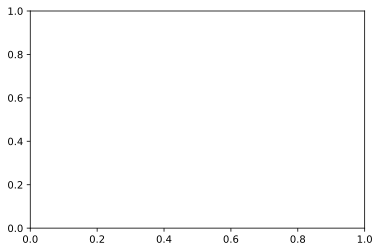

In [41]:
import matplotlib.pyplot as plt
import numpy as np

translator, sentence = translator, 'jag saknar min familj . '

translation, weights = translator.translate_with_attention([sentence])[0]
weights = np.array(weights)

fig, ax = plt.subplots()
# heatmap = ax.pcolor(weights, cmap='Blues_r', vmin=0., vmax=1.)

# ax.xaxis.tick_top()
# ax.set_xticks(np.arange(weights.shape[1]) + 0.5, minor=False)
# ax.set_yticks(np.arange(weights.shape[0]) + 0.5, minor=False)
# ax.set_xticklabels(sentence.split(), minor=False, rotation=40)
# ax.set_yticklabels(translation.split(), minor=False)
# ax.invert_yaxis()

Here is an example.

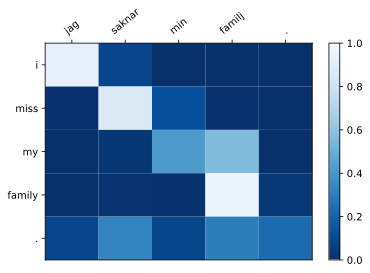

In [42]:
plot_attention(translator, 'jag saknar min familj . ')

#### 🤔 Task 7: Use these heatmaps to inspect the attention patterns for selected Swedish sentences

Try to find sentences for which the model produces reasonably good English translations. If you don't speak Swedish, use sentences from the validation data. It might be interesting to look at examples where the Swedish and the English word order differ substantially.

Based on your exploration, **answer the following questions:**

- What sentences did you try out? What patterns did you spot? Include example heatmaps in your notebook.  
    - we tried 'jag talar inte svenska . '. from the plot we can find that the different order of 'talar inte' and 'dont speak' in 2 languages makes the attention widely connected to almost all related words but not only 1-to-1 like previous 'jag saknar min familj . '


- Based on what you know about attention, did you expect your results? Was there anything surprising in them?
    - It's expected, the model needs to 'attend to' both talar and inte to get correct tranlation without misunderstanding or wrongly ordered sentence like 'i speak not swidish' 
    - but there is something suprising that the word 'svenska' didnt corectly translated and the attention seems not properly distributed. Which it's supposed to weight on only 1 word and easily translated from 'svenska' towords 'swidish'. It might be affected by the previous 'talar-inte-' structure and make the model overcomlicated the task.

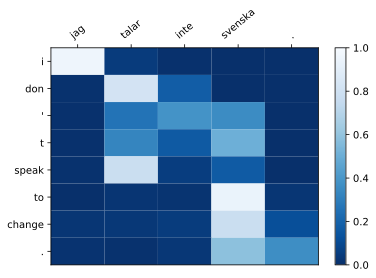

In [47]:
plot_attention(translator, 'jag talar inte svenska . ')

**🥳 Congratulations on finishing this lab! 🥳**